In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear as Lin

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    MLP,
    PointTransformerConv,
    fps,
    global_mean_pool,
    knn,
    knn_graph,
)
from torch_geometric.typing import WITH_TORCH_CLUSTER
from torch_geometric.utils import scatter

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")

In [2]:
from torch_geometric.transforms import KNNGraph
import process_3dm_file
import nyc_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Change this variable to configure the 'density' of the point cloud.
# SAMPLES refers to the number of vertices.
SAMPLES = 32768
data_list = process_3dm_file.get_all_models_from_json(samples=SAMPLES)

dataset = nyc_dataset.NYCDataset(data_list)

dataset.transform = T.Compose([KNNGraph(k=6)])

Loading vertices from file: NYC_3DModel_BK01.json
Loading vertices from file: NYC_3DModel_BK02.json
Loading vertices from file: NYC_3DModel_BK03.json
Loading vertices from file: NYC_3DModel_BK04.json
Loading vertices from file: NYC_3DModel_BK05.json
Loading vertices from file: NYC_3DModel_BK06.json
Loading vertices from file: NYC_3DModel_BK07.json
Loading vertices from file: NYC_3DModel_BK08.json
Loading vertices from file: NYC_3DModel_BK09.json
Loading vertices from file: NYC_3DModel_BK10.json
Loading vertices from file: NYC_3DModel_BK11.json
Loading vertices from file: NYC_3DModel_BK12.json
Loading vertices from file: NYC_3DModel_BK13.json
Loading vertices from file: NYC_3DModel_BK14.json
Loading vertices from file: NYC_3DModel_BK15.json
Loading vertices from file: NYC_3DModel_BK16.json
Loading vertices from file: NYC_3DModel_BK17.json
Loading vertices from file: NYC_3DModel_BK18.json
Loading vertices from file: NYC_3DModel_BX01.json
Loading vertices from file: NYC_3DModel_BX02.json


In [3]:
def split_list(a_list):
    half = len(a_list)//2
    return a_list[:half], a_list[half:]

def get_by_class(class_name):
    return [data for data in dataset if data.y == class_name]

train_dataset = []
test_dataset = []

for i in range(5):
    list = get_by_class(i)
    train_list, test_list = split_list(list)
    train_dataset += train_list
    test_dataset += test_list

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [4]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.lin_in = Lin(in_channels, in_channels)
        self.lin_out = Lin(out_channels, out_channels)

        self.pos_nn = MLP([3, 64, out_channels], norm=None, plain_last=False)

        self.attn_nn = MLP([out_channels, 64, out_channels], norm=None,
                           plain_last=False)

        self.transformer = PointTransformerConv(in_channels, out_channels,
                                                pos_nn=self.pos_nn,
                                                attn_nn=self.attn_nn)

    def forward(self, x, pos, edge_index):
        x = self.lin_in(x).relu()
        x = self.transformer(x, pos, edge_index)
        x = self.lin_out(x).relu()
        return x


class TransitionDown(torch.nn.Module):
    """Samples the input point cloud by a ratio percentage to reduce
    cardinality and uses an mlp to augment features dimensionnality.
    """
    def __init__(self, in_channels, out_channels, ratio=0.25, k=16):
        super().__init__()
        self.k = k
        self.ratio = ratio
        self.mlp = MLP([in_channels, out_channels], plain_last=False)

    def forward(self, x, pos, batch):
        # FPS sampling
        id_clusters = fps(pos, ratio=self.ratio, batch=batch)

        # compute for each cluster the k nearest points
        sub_batch = batch[id_clusters] if batch is not None else None

        # beware of self loop
        id_k_neighbor = knn(pos, pos[id_clusters], k=self.k, batch_x=batch,
                            batch_y=sub_batch)

        # transformation of features through a simple MLP
        x = self.mlp(x)

        # Max pool onto each cluster the features from knn in points
        x_out = scatter(x[id_k_neighbor[1]], id_k_neighbor[0], dim=0,
                        dim_size=id_clusters.size(0), reduce='max')

        # keep only the clusters and their max-pooled features
        sub_pos, out = pos[id_clusters], x_out
        return out, sub_pos, sub_batch


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dim_model, k=16):
        super().__init__()
        self.k = k

        # dummy feature is created if there is none given
        in_channels = max(in_channels, 1)

        # first block
        self.mlp_input = MLP([in_channels, dim_model[0]], plain_last=False)

        self.transformer_input = TransformerBlock(in_channels=dim_model[0],
                                                  out_channels=dim_model[0])
        # backbone layers
        self.transformers_down = torch.nn.ModuleList()
        self.transition_down = torch.nn.ModuleList()

        for i in range(len(dim_model) - 1):
            # Add Transition Down block followed by a Transformer block
            self.transition_down.append(
                TransitionDown(in_channels=dim_model[i],
                               out_channels=dim_model[i + 1], k=self.k))

            self.transformers_down.append(
                TransformerBlock(in_channels=dim_model[i + 1],
                                 out_channels=dim_model[i + 1]))

        # class score computation
        self.mlp_output = MLP([dim_model[-1], 64, out_channels], norm=None)

    def forward(self, x, pos, batch=None):

        # add dummy features in case there is none
        if x is None:
            x = torch.ones((pos.shape[0], 1), device=pos.get_device())

        # first block
        x = self.mlp_input(x)
        edge_index = knn_graph(pos, k=self.k, batch=batch)
        x = self.transformer_input(x, pos, edge_index)

        # backbone
        for i in range(len(self.transformers_down)):
            x, pos, batch = self.transition_down[i](x, pos, batch=batch)

            edge_index = knn_graph(pos, k=self.k, batch=batch)
            x = self.transformers_down[i](x, pos, edge_index)

        # GlobalAveragePooling
        x = global_mean_pool(x, batch)

        # Class score
        out = self.mlp_output(x)

        return F.log_softmax(out, dim=-1)


In [5]:
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        # print(data.x, data.pos, data.batch)
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.pos, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    correct = 0
    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.pos, data.batch).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    return correct / len(loader.dataset), all_preds, all_labels

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(0, 5,
            dim_model=[32, 64, 128, 256, 512], k=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20,
                                            gamma=0.5)

stats = []

Epoch 001, Loss: 208.4057, Test: 0.2000
Epoch 002, Loss: 158.8418, Test: 0.5000
Epoch 003, Loss: 89.3449, Test: 0.3667
Epoch 004, Loss: 31.3650, Test: 0.4333
Epoch 005, Loss: 8.8012, Test: 0.4333
Epoch 006, Loss: 18.1351, Test: 0.3667
Epoch 007, Loss: 9.7270, Test: 0.2667
Epoch 008, Loss: 4.2732, Test: 0.5333
Epoch 009, Loss: 17.4864, Test: 0.2333
Epoch 010, Loss: 20.3033, Test: 0.4333
Epoch 011, Loss: 21.6024, Test: 0.2333
Epoch 012, Loss: 5.8013, Test: 0.6000
Epoch 013, Loss: 23.3654, Test: 0.2333
Epoch 014, Loss: 24.5789, Test: 0.3000
Epoch 015, Loss: 20.9648, Test: 0.6333
Epoch 016, Loss: 11.8265, Test: 0.4000
Epoch 017, Loss: 1.7535, Test: 0.4667
Epoch 018, Loss: 1.9738, Test: 0.4333
Epoch 019, Loss: 2.1226, Test: 0.3333
Epoch 020, Loss: 5.0052, Test: 0.4333
Epoch 021, Loss: 0.9259, Test: 0.5667
Epoch 022, Loss: 4.2283, Test: 0.3333
Epoch 023, Loss: 1.2174, Test: 0.5667
Epoch 024, Loss: 0.6081, Test: 0.3667
Epoch 025, Loss: 0.8423, Test: 0.4667
Epoch 026, Loss: 0.5406, Test: 0.466

In [13]:
for epoch in range(100, 101):
    loss = train()
    test_acc, predicted_labels, true_labels = test(test_loader)
    print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Test: {test_acc:.4f}')
    stats.append((epoch, loss, test_acc))
    scheduler.step()

Epoch 100, Loss: 0.3548, Test: 0.7667


In [14]:
# Specify the file path to save the model
model_path = 'models/model100.pt'

# Save the model
torch.save(model.state_dict(), model_path)

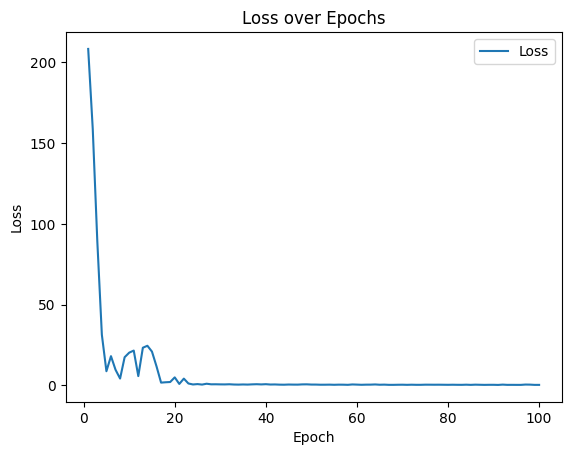

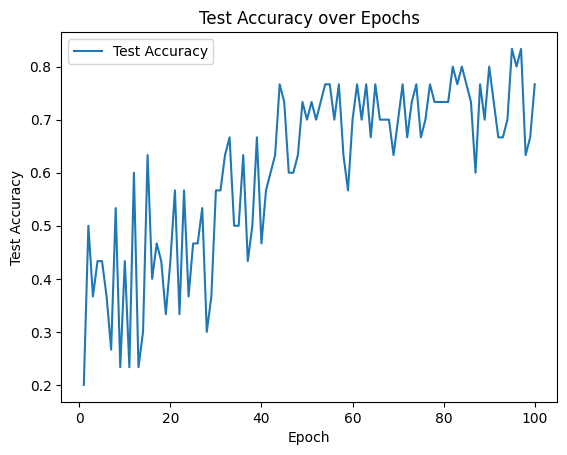

In [15]:
import matplotlib.pyplot as plt

# Extract the loss and test accuracy values from the stats list
epochs = [epoch for epoch, _, _ in stats]
losses = [loss for _, loss, _ in stats]
test_accs = [test_acc for _, _, test_acc in stats]

# Plot the loss
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
# plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot the test accuracy
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

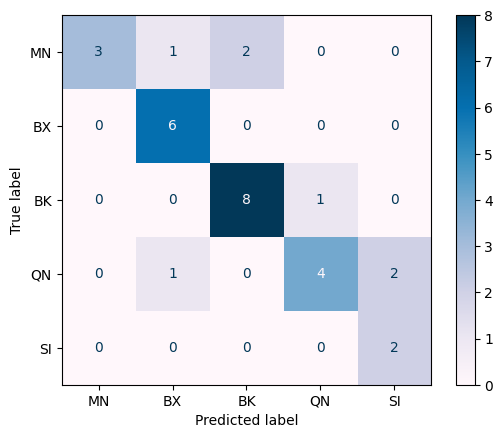

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from matplotlib import pyplot as plt

classes = ["MN", "BX", "BK", "QN", "SI"]

# Create the confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes) 
# Then just plot it: 
disp.plot(cmap='PuBu') 
# And show it: 
plt.show()